# Анализ оттока клиентов банка (поиск инсайтов, составление рекомендаций стейкхолдерам)

### Цель

Цель - исследования дать рекомендации по удержанию клиентов тем самым снизив их отток.

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Чтение данных

In [2]:
# Загрузим датасет и посмотрим на структуру данных
df = pd.read_csv("Customer-Churn-Records.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

1. RowNumber - номер строки
2. CustomerId - ID клиента
3. Surname - фамилия
4. CreditScore - кредитный рейтинг
5. Geography - страна
6. Gender - пол
7. Age - возраст
8. Tenure - частота использования кредитной карты
9. Balance - баланс
10. NumOfProducts - количество продуктов банка
11. HasCrCard - наличие кредитной карты
12. IsActiveMember - активный клиент
13. EstimatedSalary - предполагаемая зарплата клиента
14. Exited - покинул банк
15. Complain - есть ли жалобы
16. Satisfaction Score - балл удовлетворенности
17. Card Type - класс карты
18. Point Earned - баллы

In [4]:
# Удалим очевидно ненужные столбцы
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_clean.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Анализ данных

In [5]:
df_clean.shape

(10000, 15)

In [6]:
df_clean.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


На первый взгляд все хорошо, нет очевидных выбросов и пропущенных значений.

In [7]:
# Посмортим на столбцы с фиксированным набором значений
for column in df_clean[['Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain', 'Satisfaction Score', 'Geography', 'Card Type']].columns:
    print(column, df_clean[column].unique())

Gender ['Female' 'Male']
Age [42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49
 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53
 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure [ 2  1  8  7  4  6  3 10  5  9  0]
NumOfProducts [1 3 2 4]
HasCrCard [1 0]
IsActiveMember [1 0]
Exited [1 0]
Complain [1 0]
Satisfaction Score [2 3 5 4 1]
Geography ['France' 'Spain' 'Germany']
Card Type ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']


Все даные корректны. Можно переходить к исследованию.

### Исследование

Построим гистограммы распределения по нечисловым столбцам и наложим гистограммы с количеством ушедших, для остальных столбцов построим матирицу корреляции

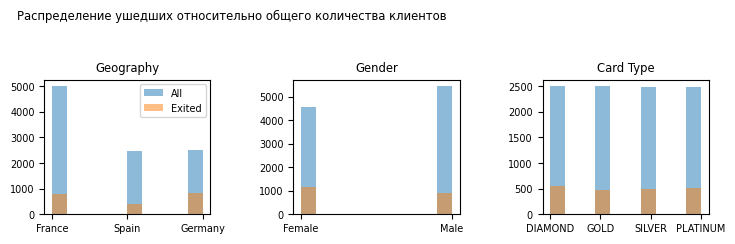

In [8]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams['font.size'] = '7'
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, column in enumerate(['Geography', 'Gender', 'Card Type']):
    plt.subplot(3, len(df_clean.columns)//3, i+1)
    plt.hist(df_clean[column], label='All', alpha=.5)
    plt.hist(df_clean[df_clean['Exited'] == 1][column], label='Exited', alpha=.5)
    plt.title(column)
    if(i==0):
        plt.legend()
plt.suptitle('Распределение ушедших относительно общего количества клиентов', x=0.25);
plt.show()

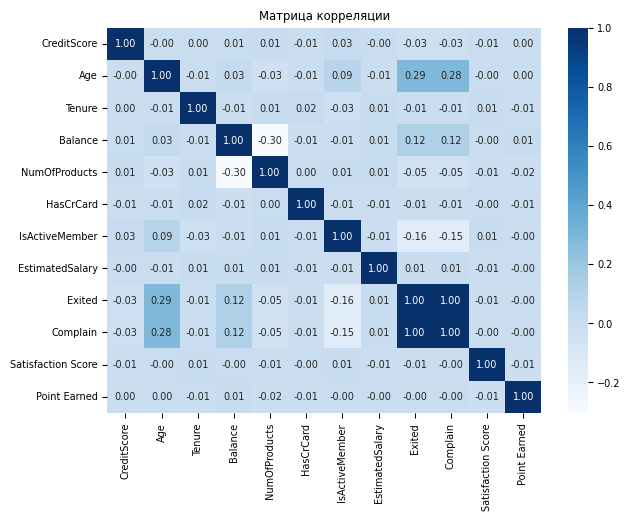

In [9]:
col_df = df_clean.select_dtypes(include=["int64","float64"]) 
plt.rcParams["figure.figsize"] = (7,5)
sns.heatmap(col_df.corr(), annot=True, cmap ='Blues', fmt=".2f")
plt.title('Матрица корреляции');

Из матрицы корреляции можно сделать выводы, что уход из банка зависит от Age, Balance, IsActiveMember, Complain (после жалоб практически 100% вероятность ухода).

Также при сравнении гистограмм распределения видно, что есть зависимость от Gender (женщины чаще меняют банк) и Geography (жители Германии активнее меняют банк)

Дальнейший анализ будем проводить без учета Complain, так как между ним и Exited прямая зависимость и модель будет работать некорректно, по сути переобучаться.

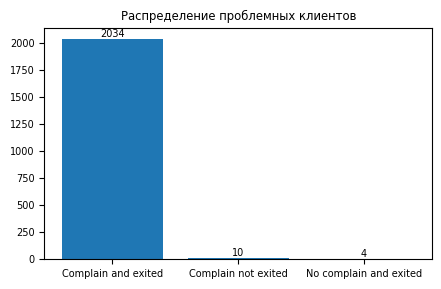

In [10]:
df_exited = df_clean[df_clean['Exited'] == 1]

vals = [len(df_clean[(df_clean['Complain'] == 1) & (df_clean['Exited'] == 1)]), 
        len(df_clean[(df_clean['Complain'] == 1) & (df_clean['Exited'] == 0)]),
        len(df_clean[(df_clean['Complain'] == 0) & (df_clean['Exited'] == 1)])
       ]
labels = ["Complain and exited", "Complain not exited", "No complain and exited"]

plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams['font.size'] = '7'
plt.subplots_adjust(wspace=0.5, hspace=0.5)
bars = plt.bar(labels, vals)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Распределение проблемных клиентов');

Подавляющее большинство клиентов уходит после жалоб, а уход довольных клиентов моловероятен.

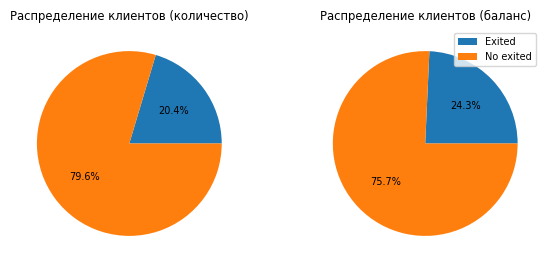

In [11]:
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams['font.size'] = '7'

plt.subplot(1, 2, 1)
vals = [len(df_clean[df_clean['Exited'] == 1]), 
        len(df_clean[df_clean['Exited'] == 0])
       ]
bars = plt.pie(vals, autopct='%1.1f%%')
plt.title('Распределение клиентов (количество)');

plt.subplot(1, 2, 2)
vals = [df_clean[df_clean['Exited'] == 1]['Balance'].sum(), 
        df_clean[df_clean['Exited'] == 0]['Balance'].sum()
       ]
bars = plt.pie(vals, autopct='%1.1f%%')
plt.title('Распределение клиентов (баланс)');

labels = ["Exited", "No exited"]
plt.legend(labels=labels);

Банк теряет каждого пятого клиента. Отток со вкладов более 24%.

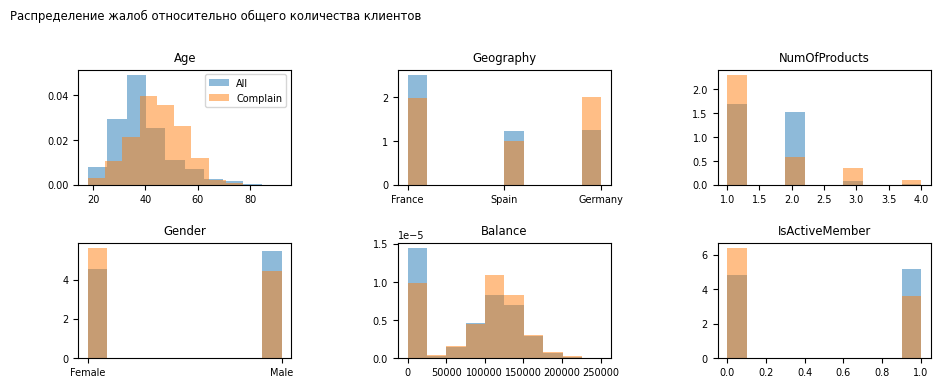

In [12]:
# построим гистограммы по количеству жалоб
plt.rcParams["figure.figsize"] = (11,6)
plt.rcParams['font.size'] = '7'
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, column in enumerate(['Age', 'Geography', 'NumOfProducts', 'Gender', 'Balance', 'IsActiveMember']):
    plt.subplot(3, len(df_clean.columns)//5, i+1)
    plt.hist(df_clean[column], label='All', density=True, alpha=.5)
    plt.hist(df_clean[df_clean['Complain'] == 1][column], label='Complain', density=True, alpha=.5)
    plt.title(column)
    if(i==0):
        plt.legend()
plt.suptitle('Распределение жалоб относительно общего количества клиентов', x=0.25);
plt.show()

Выводы:
1. Недовольство сервисами банка больше среди людей в возрасте 40-60 лет.
2. Есть проблемы в Германии.
3. Оптимальное количество используемых сервисов 2. Видимо есть проблемы с частью продуктов банка.
4. Женщины недовольны работой банка гораздо больше чем мужчины.
5. Много жалоб от неактивных клиентов и клиентов с нулевым балансом. Возможно есть сложности с использованием сервисов банка.

### Построение модели

In [13]:
df_clean_imp = df_clean[['Age', 'Balance', 'IsActiveMember', 'Gender', 'Geography', 'NumOfProducts', 'Exited']].copy()
# Gender - label encoded - Female=0, Male=1
# Geography - one-hot encoded
df_clean_imp['Gender'] = df_clean_imp['Gender'].map({'Female': 0, "Male": 1})
df_clean_imp = pd.get_dummies(df_clean_imp, columns=['Geography'], drop_first=True)

# смотрим, что получилось
df_clean_imp.head(3)

,Age,Balance,IsActiveMember,Gender,NumOfProducts,Exited,Geography_Germany,Geography_Spain
0,42,0.00,1,0,1,1,False,False
1,41,83807.86,1,0,1,0,False,True
2,42,159660.80,0,0,3,1,False,False


In [14]:
X = df_clean_imp.drop('Exited', axis=1)
y = df_clean_imp['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
y_test_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

In [16]:
print('TEST')
print(classification_report(y_train, y_train_pred, digits=3))
print('TRAIN')
print(classification_report(y_test, y_test_pred, digits=3))

TEST
              precision    recall  f1-score   support

           0      0.827     0.965     0.891      6370
           1      0.606     0.209     0.311      1630

    accuracy                          0.811      8000
   macro avg      0.716     0.587     0.601      8000
weighted avg      0.782     0.811     0.772      8000

TRAIN
              precision    recall  f1-score   support

           0      0.825     0.970     0.892      1592
           1      0.633     0.199     0.302       408

    accuracy                          0.813      2000
   macro avg      0.729     0.585     0.597      2000
weighted avg      0.786     0.813     0.772      2000



Модель не переобучилась и позволяет с достаточной точностью предсказать поведение клиента.

С дугой стороны модели очень сложно предугадать уход клиента (recall=0.20).

In [17]:
model_tree = DecisionTreeClassifier(max_depth=7, random_state=42)
model_tree.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
y_test_pred = model_tree.predict(X_test_scaled)
y_train_pred = model_tree.predict(X_train_scaled)

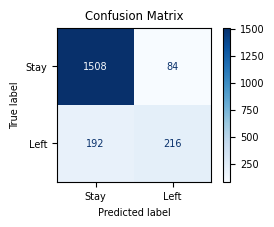

In [22]:
cm = confusion_matrix(y_test, y_test_pred)

plt.rcParams["figure.figsize"] = (3,2)
plt.rcParams['font.size'] = '7'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stay", "Left"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [20]:
print('TEST')
print(classification_report(y_train, y_train_pred, digits=3))
print('TRAIN')
print(classification_report(y_test, y_test_pred, digits=3))

TEST
              precision    recall  f1-score   support

           0      0.887     0.959     0.922      6370
           1      0.766     0.523     0.622      1630

    accuracy                          0.870      8000
   macro avg      0.827     0.741     0.772      8000
weighted avg      0.863     0.870     0.861      8000

TRAIN
              precision    recall  f1-score   support

           0      0.887     0.947     0.916      1592
           1      0.720     0.529     0.610       408

    accuracy                          0.862      2000
   macro avg      0.804     0.738     0.763      2000
weighted avg      0.853     0.862     0.854      2000



Результат получился гораздо лучше, чем при использовании логистической регресии. Данная модель точно предсказывает более 50% случаев ухода клиентов по сравнению с 20% предыдущей модели.

# Выводы

1. Большое количество жалоб в Германии.
2. У клиентов в возрасте 40-60 лет растет неудовлетворенноть сервисами банка.
3. Среди женщин процент недовольных сервисами банка выше чем у мужчин.
5. С частью сервисами есть проблемы, это видно из обращений клиентов с нулевым балансом, неактивных клиентов, а также клиентов с большим количеством подключеных продуктов.
6. Из всех продуктов банка реально нравится клиентам только комбинация из двух продуктов (возможно и один, если он подключается как дополнение к другим).
7. Каждый пятый клиент недоволен работой банка (отток клиентов 20%, отток вкладов 24%).